In [40]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import datasets, linear_model, svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import math
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.feature_selection import SelectFromModel
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

In [41]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")
trainCopy=train.copy()
testCopy=test.copy()
train=shuffle(train)

In [42]:
train.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
16419,44918,Sales & Marketing,region_15,Bachelor's,m,other,2,46,3.0,4,1,0,54,0
30613,8697,Sales & Marketing,region_22,Master's & above,m,sourcing,1,56,5.0,11,0,0,49,0
40061,56471,Analytics,region_22,Bachelor's,m,other,2,29,4.0,2,1,0,87,0
3187,3631,Sales & Marketing,region_4,Master's & above,m,sourcing,2,40,1.0,3,0,0,51,0
40450,63651,Procurement,region_9,Bachelor's,m,other,1,31,4.0,2,1,0,69,0


In [43]:
train.nunique()

employee_id             54808
department                  9
region                     34
education                   3
gender                      2
recruitment_channel         3
no_of_trainings            10
age                        41
previous_year_rating        5
length_of_service          35
KPIs_met >80%               2
awards_won?                 2
avg_training_score         61
is_promoted                 2
dtype: int64

In [44]:
train.drop(['employee_id'],axis=1,inplace=True)
test.drop(['employee_id'],axis=1,inplace=True)
train.shape,test.shape

((54808, 13), (23490, 12))

In [45]:
train.is_promoted.value_counts()

0    50140
1     4668
Name: is_promoted, dtype: int64

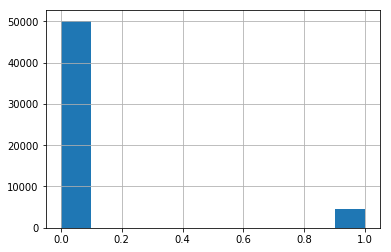

In [46]:
train.is_promoted.hist()

Encoding data 

In [47]:

labels = train['recruitment_channel'].astype('category').cat.categories.tolist()
recChannelMap = {'recruitment_channel' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}

labels = train['department'].astype('category').cat.categories.tolist()
departmentMap = {'department' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}

labels = train['region'].astype('category').cat.categories.tolist()
regionMap = {'region' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}

In [48]:
train.replace(departmentMap, inplace=True)
train.replace(regionMap, inplace=True)
train.replace(recChannelMap, inplace=True)


test.replace(departmentMap, inplace=True)
test.replace(regionMap, inplace=True)
test.replace(recChannelMap, inplace=True)

In [49]:
train['previous_year_rating']=train['previous_year_rating'].fillna(train.previous_year_rating.mode()[0])
train['education'] = train['education'].fillna(train['education'].mode()[0])

test['previous_year_rating']=test['previous_year_rating'].fillna(test.previous_year_rating.mode()[0])
test['education'] = test['education'].fillna(test['education'].mode()[0])

In [50]:

education_mapper = {"Master's & above":3, "Bachelor's":2,"Below Secondary":1}
gender_mapper = {"m":1, "f":2}

In [51]:
train['education_scaled'] = train['education'].replace(education_mapper)
test['education_scaled'] = test['education'].replace(education_mapper)
train['education']=train['education_scaled']
train.drop(['education_scaled'],axis=1,inplace=True)
train['gender'] = train['gender'].replace(gender_mapper)
test['gender'] = test['gender'].replace(gender_mapper)
test['education']=test['education_scaled']
test.drop(['education_scaled'],axis=1,inplace=True)

In [52]:
train.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
16419,8,7,2,1,1,2,46,3.0,4,1,0,54,0
30613,8,15,3,1,3,1,56,5.0,11,0,0,49,0
40061,1,15,2,1,1,2,29,4.0,2,1,0,87,0
3187,8,29,3,1,3,2,40,1.0,3,0,0,51,0
40450,6,34,2,1,1,1,31,4.0,2,1,0,69,0


In [53]:
train['joining_age']=train['age']-train['length_of_service']
test['joining_age']=test['age']-test['length_of_service']

train['training_hours']=train['no_of_trainings']*train['avg_training_score']
test['training_hours']=test['no_of_trainings']*test['avg_training_score']

In [54]:
train.describe()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,joining_age,training_hours
count,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000
mean,5.972796,16.428970,2.257627,1.297621,1.868158,1.253011,34.803915,3.304481,5.865512,0.351974,0.023172,63.386750,0.085170,28.938403,79.770636
std,2.506046,8.764954,0.469717,0.457216,0.980713,0.609264,7.660169,1.214770,4.265094,0.477590,0.150450,13.371559,0.279137,5.825101,43.879135
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000,0.000000,17.000000,39.000000
25%,5.000000,12.000000,2.000000,1.000000,1.000000,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000,0.000000,25.000000,53.000000
50%,6.000000,15.000000,2.000000,1.000000,1.000000,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000,0.000000,27.000000,64.000000
75%,8.000000,22.000000,3.000000,2.000000,3.000000,1.000000,39.000000,4.000000,7.000000,1.000000,0.000000,76.000000,0.000000,31.000000,84.000000
max,9.000000,34.000000,3.000000,2.000000,3.000000,10.000000,60.000000,5.000000,37.000000,1.000000,1.000000,99.000000,1.000000,58.000000,710.000000


In [55]:
X_selected=train[['education',
  'department','gender',
  'no_of_trainings',
  'age',
  'previous_year_rating',
  'KPIs_met >80%',
  'awards_won?',
  'avg_training_score']]

In [56]:
y=train[['is_promoted']]

In [57]:
import warnings
warnings.filterwarnings("ignore")

In [58]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X_selected)

In [59]:
scaled_data_frame=pd.DataFrame(scaled_data)
scaled_data_frame.columns=X_selected.columns
X_selected_scaled=scaled_data_frame
X_selected_scaled.head()

,education,department,gender,no_of_trainings,age,previous_year_rating,KPIs_met >80%,awards_won?,avg_training_score
0,-0.548477,0.808933,-0.650947,1.226063,1.461611,-0.250651,1.356878,-0.154018,-0.702000
1,1.580483,0.808933,-0.650947,-0.415276,2.767077,1.395766,-0.736986,-0.154018,-1.075931
2,-0.548477,-1.984338,-0.650947,1.226063,-0.757681,0.572557,1.356878,-0.154018,1.765947
3,1.580483,0.808933,-0.650947,1.226063,0.678331,-1.897069,-0.736986,-0.154018,-0.926359
4,-0.548477,0.010855,-0.650947,-0.415276,-0.496588,0.572557,1.356878,-0.154018,0.419794


In [60]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [61]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('XGB', XGBClassifier()))
models.append(('LGBM', LGBMClassifier()))
models.append(('RF', RandomForestClassifier()))

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X_selected_scaled,y, test_size=0.33, random_state=33)

In [63]:
auc_score=[]
f1_score=[]
names=[]
for name, model in models:
    model.fit(X_train,y_train)
    y_pred=model.predict(X_test)
    names.append(name)
    auc=metrics.roc_auc_score(y_test, y_pred)
    f1=metrics.f1_score(y_test, y_pred)
    auc_score.append(auc)
    f1_score.append(f1)
    print(name,auc,f1)

LR 0.5314187037134993 0.120427687113112
LDA 0.5550492607496802 0.19603960396039605
KNN 0.6155099816764117 0.3545331529093369
CART 0.6932269407835696 0.45934284766013944
NB 0.5527318557821026 0.18925579103006407
XGB 0.6282253900826574 0.40586797066014674
LGBM 0.6691399328994082 0.5004566210045662
RF 0.6645974642649339 0.44418331374853115


From above we can observe that the Highest f1 score is obtained using the LGBM classifier thus we will tune the model based on f1 score for improvement

num_leaves = 2: 
 the auc value is  0.557069728411559
 the f1 score is  0.20445459737292973
num_leaves = 3: 
 the auc value is  0.5719091058814061
 the f1 score is  0.25098039215686274
num_leaves = 4: 
 the auc value is  0.6042570854142513
 the f1 score is  0.3433703116745906
num_leaves = 5: 
 the auc value is  0.6349429624971576
 the f1 score is  0.4229607250755287
num_leaves = 6: 
 the auc value is  0.6363734034599149
 the f1 score is  0.4256384576865298
num_leaves = 9: 
 the auc value is  0.6648026719032338
 the f1 score is  0.4925588094095055
num_leaves = 18: 
 the auc value is  0.6749976488786205
 the f1 score is  0.5143935818782445
num_leaves = 21: 
 the auc value is  0.6736476841103497
 the f1 score is  0.5111006140765234
num_leaves = 27: 
 the auc value is  0.6722372452250011
 the f1 score is  0.507321681624941
num_leaves = 31: 
 the auc value is  0.6735569729347328
 the f1 score is  0.5103773584905661
num_leaves = 61: 
 the auc value is  0.6749269397804123
 the f1 score is  0.

Text(0, 0.5, 'scores ')

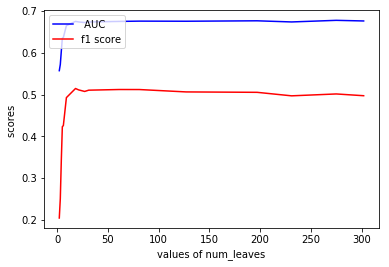

In [64]:
#num_leaves

X_train_lgbm, X_test_lgbm, y_train_lgbm, y_test_lgbm = train_test_split(X_selected_scaled,y, test_size=0.33, random_state=225)

auc=[]
f1=[]
num_leaves= [2,3,4,5,6,9,18,21,27, 31, 61, 81, 127, 197, 231, 275, 302]
for i in num_leaves:
    print('num_leaves = {}: '.format(i))
    clf_lgb = LGBMClassifier(num_leaves=i)
    clf_lgb.fit(X_train_lgbm, y_train_lgbm)
    predict = clf_lgb.predict(X_test_lgbm)
    auc.append(metrics.roc_auc_score(y_test_lgbm, predict))
    f1.append(metrics.f1_score(y_test_lgbm, predict))
    print(" the auc value is ",metrics.roc_auc_score(y_test_lgbm, predict))
    print(" the f1 score is ",metrics.f1_score(y_test_lgbm, predict))

    
from matplotlib.legend_handler import HandlerLine2D
line1 = plt.plot(num_leaves, auc, color="blue", label=" AUC")
line2 = plt.plot(num_leaves, f1,color="red", label="f1 score")
plt.legend(loc='upper left')
plt.xlabel('values of num_leaves')
plt.ylabel("scores ")


bagging_fraction = 0.1: 
 the auc value is  0.6735569729347328
 the f1 score is  0.5103773584905661
bagging_fraction = 0.2: 
 the auc value is  0.6735569729347328
 the f1 score is  0.5103773584905661
bagging_fraction = 0.3: 
 the auc value is  0.6735569729347328
 the f1 score is  0.5103773584905661
bagging_fraction = 0.4: 
 the auc value is  0.6735569729347328
 the f1 score is  0.5103773584905661
bagging_fraction = 0.5: 
 the auc value is  0.6735569729347328
 the f1 score is  0.5103773584905661
bagging_fraction = 0.7: 
 the auc value is  0.6735569729347328
 the f1 score is  0.5103773584905661
bagging_fraction = 0.8: 
 the auc value is  0.6735569729347328
 the f1 score is  0.5103773584905661
bagging_fraction = 0.9: 
 the auc value is  0.6735569729347328
 the f1 score is  0.5103773584905661


Text(0, 0.5, 'scores ')

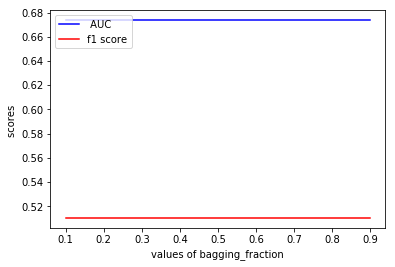

In [65]:
#bagging_fraction

X_train_lgbm, X_test_lgbm, y_train_lgbm, y_test_lgbm = train_test_split(X_selected_scaled,y, test_size=0.33, random_state=225)

auc=[]
f1=[]
bagging_fraction=[0.1,0.2,0.3,0.4,0.5, 0.7, 0.8, 0.9]
for i in bagging_fraction:
    print('bagging_fraction = {}: '.format(i))
    clf_lgb = LGBMClassifier(bagging_fraction=i)
    clf_lgb.fit(X_train_lgbm, y_train_lgbm)
    predict = clf_lgb.predict(X_test_lgbm)
    auc.append(metrics.roc_auc_score(y_test_lgbm, predict))
    f1.append(metrics.f1_score(y_test_lgbm, predict))
    print(" the auc value is ",metrics.roc_auc_score(y_test_lgbm, predict))
    print(" the f1 score is ",metrics.f1_score(y_test_lgbm, predict))

    
line1 = plt.plot(bagging_fraction, auc, color="blue", label=" AUC")
line2 = plt.plot(bagging_fraction, f1,color="red", label="f1 score")
plt.legend(loc='upper left')
plt.xlabel('values of bagging_fraction')
plt.ylabel("scores ")


learning_rate = 0.001: 
 the auc value is  0.5
 the f1 score is  0.0
learning_rate = 0.005: 
 the auc value is  0.5
 the f1 score is  0.0
learning_rate = 0.01: 
 the auc value is  0.6271702871905775
 the f1 score is  0.4051413881748072
learning_rate = 0.05: 
 the auc value is  0.6714622965403361
 the f1 score is  0.5066539923954373
learning_rate = 0.1: 
 the auc value is  0.675540336653182
 the f1 score is  0.5148514851485149
learning_rate = 0.3: 
 the auc value is  0.6780861163957776
 the f1 score is  0.5126320624712907
learning_rate = 0.5: 
 the auc value is  0.6729929164375864
 the f1 score is  0.48845470692717585


Text(0, 0.5, 'scores ')

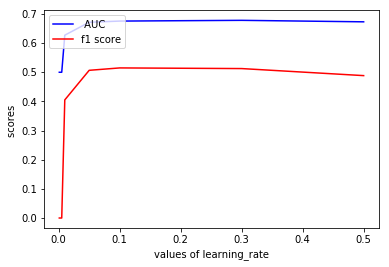

In [66]:
#learning_rate

X_train_lgbm, X_test_lgbm, y_train_lgbm, y_test_lgbm = train_test_split(X_selected_scaled,y, test_size=0.33, random_state=12)

auc=[]
f1=[]
learning_rate=[0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5]
for i in learning_rate:
    print('learning_rate = {}: '.format(i))
    clf_lgb = LGBMClassifier(learning_rate=i)
    clf_lgb.fit(X_train_lgbm, y_train_lgbm)
    predict = clf_lgb.predict(X_test_lgbm)
    auc.append(metrics.roc_auc_score(y_test_lgbm, predict))
    f1.append(metrics.f1_score(y_test_lgbm, predict))
    print(" the auc value is ",metrics.roc_auc_score(y_test_lgbm, predict))
    print(" the f1 score is ",metrics.f1_score(y_test_lgbm, predict))


line1 = plt.plot(learning_rate, auc, color="blue", label=" AUC")
line2 = plt.plot(learning_rate, f1,color="red", label="f1 score")
plt.legend(loc='upper left')
plt.xlabel('values of learning_rate')
plt.ylabel("scores ")


is_unbalance = True: 
 the auc value is  0.8124327113128424
 the f1 score is  0.37779914823464766
is_unbalance = False: 
 the auc value is  0.675540336653182
 the f1 score is  0.5148514851485149


Text(0, 0.5, 'scores ')

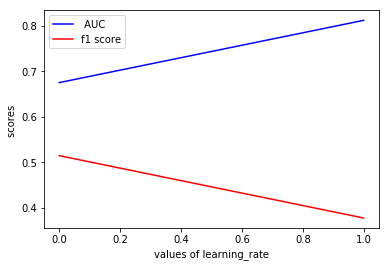

In [67]:
#is_unbalance': choice([True, False]),

X_train_lgbm, X_test_lgbm, y_train_lgbm, y_test_lgbm = train_test_split(X_selected_scaled,y, test_size=0.33, random_state=12)

auc=[]
f1=[]
is_unbalance=[True, False]
for i in is_unbalance:
    print('is_unbalance = {}: '.format(i))
    clf_lgb = LGBMClassifier(is_unbalance=i)
    clf_lgb.fit(X_train_lgbm, y_train_lgbm)
    predict = clf_lgb.predict(X_test_lgbm)
    auc.append(metrics.roc_auc_score(y_test_lgbm, predict))
    f1.append(metrics.f1_score(y_test_lgbm, predict))
    print(" the auc value is ",metrics.roc_auc_score(y_test_lgbm, predict))
    print(" the f1 score is ",metrics.f1_score(y_test_lgbm, predict))


line1 = plt.plot(is_unbalance, auc, color="blue", label=" AUC")
line2 = plt.plot(is_unbalance, f1,color="red", label="f1 score")
plt.legend(loc='upper left')
plt.xlabel('values of learning_rate')
plt.ylabel("scores ")


max_bin = 3: 
 the auc value is  0.5354215031326003
 the f1 score is  0.13372093023255813
max_bin = 5: 
 the auc value is  0.595591299118691
 the f1 score is  0.3137254901960785
max_bin = 10: 
 the auc value is  0.6451292481805982
 the f1 score is  0.44249512670565305
max_bin = 12: 
 the auc value is  0.6608447451665806
 the f1 score is  0.4796942188246536
max_bin = 18: 
 the auc value is  0.667879093390253
 the f1 score is  0.49856733524355296
max_bin = 20: 
 the auc value is  0.6705839990138412
 the f1 score is  0.5052430886558626
max_bin = 22: 
 the auc value is  0.6714320649664804
 the f1 score is  0.5064133016627078
max_bin = 24: 
 the auc value is  0.6677374854173669
 the f1 score is  0.4992812649736464
max_bin = 26: 
 the auc value is  0.6765300105787073
 the f1 score is  0.5152224824355972
max_bin = 28: 
 the auc value is  0.6728354310295936
 the f1 score is  0.5082664147378365


Text(0, 0.5, 'scores ')

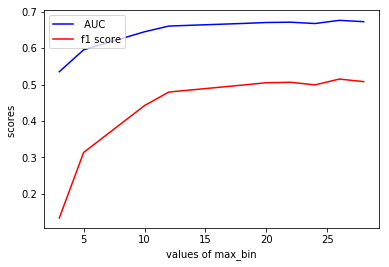

In [74]:
#max_bin': choice([3, 5, 10, 12, 18, 20, 22,24,26,28]),

X_train_lgbm, X_test_lgbm, y_train_lgbm, y_test_lgbm = train_test_split(X_selected_scaled,y, test_size=0.33, random_state=12)

auc=[]
f1=[]
max_bin=[3, 5, 10, 12, 18, 20, 22,24,26,28]
for i in max_bin:
    print('max_bin = {}: '.format(i))
    clf_lgb = LGBMClassifier(max_bin=i)
    clf_lgb.fit(X_train_lgbm, y_train_lgbm)
    predict = clf_lgb.predict(X_test_lgbm)
    auc.append(metrics.roc_auc_score(y_test_lgbm, predict))
    f1.append(metrics.f1_score(y_test_lgbm, predict))
    print(" the auc value is ",metrics.roc_auc_score(y_test_lgbm, predict))
    print(" the f1 score is ",metrics.f1_score(y_test_lgbm, predict))


line1 = plt.plot(max_bin, auc, color="blue", label=" AUC")
line2 = plt.plot(max_bin, f1,color="red", label="f1 score")
plt.legend(loc='upper left')
plt.xlabel('values of max_bin')
plt.ylabel("scores ")


bagging_freq = 3: 
 the auc value is  0.674394154880388
 the f1 score is  0.5116279069767442
bagging_freq = 9: 
 the auc value is  0.674394154880388
 the f1 score is  0.5116279069767442
bagging_freq = 11: 
 the auc value is  0.674394154880388
 the f1 score is  0.5116279069767442
bagging_freq = 15: 
 the auc value is  0.674394154880388
 the f1 score is  0.5116279069767442
bagging_freq = 17: 
 the auc value is  0.674394154880388
 the f1 score is  0.5116279069767442
bagging_freq = 23: 
 the auc value is  0.674394154880388
 the f1 score is  0.5116279069767442
bagging_freq = 31: 
 the auc value is  0.674394154880388
 the f1 score is  0.5116279069767442


Text(0, 0.5, 'scores ')

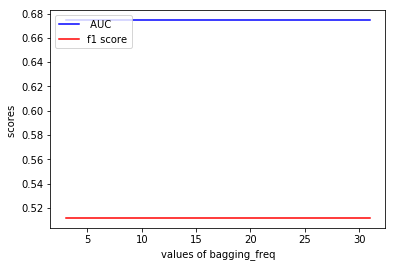

In [69]:
#bagging_freq': choice([3, 9, 11, 15, 17, 23, 31]),

X_train_lgbm, X_test_lgbm, y_train_lgbm, y_test_lgbm = train_test_split(X_selected_scaled,y, test_size=0.33, random_state=100)

auc=[]
f1=[]
bagging_freq=[3, 9, 11, 15, 17, 23, 31]
for i in bagging_freq:
    print('bagging_freq = {}: '.format(i))
    clf_lgb = LGBMClassifier(bagging_freq=i)
    clf_lgb.fit(X_train_lgbm, y_train_lgbm)
    predict = clf_lgb.predict(X_test_lgbm)
    auc.append(metrics.roc_auc_score(y_test_lgbm, predict))
    f1.append(metrics.f1_score(y_test_lgbm, predict))
    print(" the auc value is ",metrics.roc_auc_score(y_test_lgbm, predict))
    print(" the f1 score is ",metrics.f1_score(y_test_lgbm, predict))


line1 = plt.plot(bagging_freq, auc, color="blue", label=" AUC")
line2 = plt.plot(bagging_freq, f1,color="red", label="f1 score")
plt.legend(loc='upper left')
plt.xlabel('values of bagging_freq')
plt.ylabel("scores ")


max_depth = 2: 
 the auc value is  0.5801646558930433
 the f1 score is  0.27519818799546997
max_depth = 3: 
 the auc value is  0.6360021586652606
 the f1 score is  0.42386831275720166
max_depth = 4: 
 the auc value is  0.6669691176792137
 the f1 score is  0.4965585054080629
max_depth = 5: 
 the auc value is  0.6724018226593056
 the f1 score is  0.509286412512219
max_depth = 6: 
 the auc value is  0.6731867536187799
 the f1 score is  0.509727626459144
max_depth = 7: 
 the auc value is  0.6706814861055146
 the f1 score is  0.5051395007342143
max_depth = 9: 
 the auc value is  0.6748769351758878
 the f1 score is  0.5135922330097088
max_depth = 11: 
 the auc value is  0.673790454249584
 the f1 score is  0.5106796116504855


Text(0, 0.5, 'scores ')

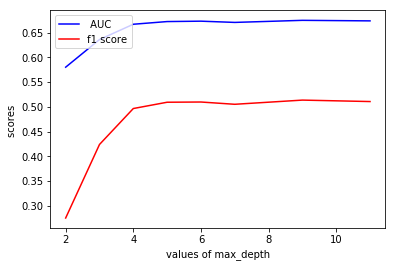

In [70]:
#max_depth': choice([3, 4, 5, 6, 7, 9, 11]),



X_train_lgbm, X_test_lgbm, y_train_lgbm, y_test_lgbm = train_test_split(X_selected_scaled,y, test_size=0.33, random_state=100)

auc=[]
f1=[]
max_depth=[2,3, 4, 5, 6, 7, 9, 11]
for i in max_depth:
    print('max_depth = {}: '.format(i))
    clf_lgb = LGBMClassifier(max_depth=i)
    clf_lgb.fit(X_train_lgbm, y_train_lgbm)
    predict = clf_lgb.predict(X_test_lgbm)
    auc.append(metrics.roc_auc_score(y_test_lgbm, predict))
    f1.append(metrics.f1_score(y_test_lgbm, predict))
    print(" the auc value is ",metrics.roc_auc_score(y_test_lgbm, predict))
    print(" the f1 score is ",metrics.f1_score(y_test_lgbm, predict))


line1 = plt.plot(max_depth, auc, color="blue", label=" AUC")
line2 = plt.plot(max_depth, f1,color="red", label="f1 score")
plt.legend(loc='upper left')
plt.xlabel('values of max_depth')
plt.ylabel("scores ")


feature_fraction = 0.2: 
 the auc value is  0.5558295830511224
 the f1 score is  0.20067264573991028
feature_fraction = 0.3: 
 the auc value is  0.5743522342578068
 the f1 score is  0.25768194070080863
feature_fraction = 0.4: 
 the auc value is  0.6184406512505783
 the f1 score is  0.3805220883534136
feature_fraction = 0.5: 
 the auc value is  0.6680454999356833
 the f1 score is  0.497457235321313
feature_fraction = 0.7: 
 the auc value is  0.6714418244965467
 the f1 score is  0.504595588235294
feature_fraction = 0.8: 
 the auc value is  0.6697380802294185
 the f1 score is  0.5018484288354897
feature_fraction = 0.9: 
 the auc value is  0.6715327556313673
 the f1 score is  0.5052922227335481


Text(0, 0.5, 'scores ')

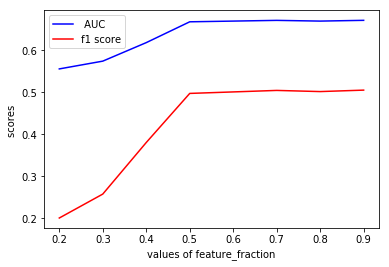

In [71]:
#'feature_fraction': choice([0.5, 0.7, 0.8, 0.9]),

X_train_lgbm, X_test_lgbm, y_train_lgbm, y_test_lgbm = train_test_split(X_selected_scaled,y, test_size=0.33, random_state=200)

auc=[]
f1=[]
feature_fraction=[0.2,0.3,0.4,0.5, 0.7, 0.8, 0.9]
for i in feature_fraction:
    print('feature_fraction = {}: '.format(i))
    clf_lgb = LGBMClassifier(feature_fraction=i)
    clf_lgb.fit(X_train_lgbm, y_train_lgbm)
    predict = clf_lgb.predict(X_test_lgbm)
    auc.append(metrics.roc_auc_score(y_test_lgbm, predict))
    f1.append(metrics.f1_score(y_test_lgbm, predict))
    print(" the auc value is ",metrics.roc_auc_score(y_test_lgbm, predict))
    print(" the f1 score is ",metrics.f1_score(y_test_lgbm, predict))


line1 = plt.plot(feature_fraction, auc, color="blue", label=" AUC")
line2 = plt.plot(feature_fraction, f1,color="red", label="f1 score")
plt.legend(loc='upper left')
plt.xlabel('values of feature_fraction')
plt.ylabel("scores ")

lambda_l1 = 0: 
 the auc value is  0.6648575239155362
 the f1 score is  0.488804192472606
lambda_l1 = 2: 
 the auc value is  0.6698359339250607
 the f1 score is  0.5004739336492892
lambda_l1 = 5: 
 the auc value is  0.6674266059341661
 the f1 score is  0.49618320610687017
lambda_l1 = 7: 
 the auc value is  0.6662823904667974
 the f1 score is  0.49448969813128896
lambda_l1 = 10: 
 the auc value is  0.665341112140163
 the f1 score is  0.49255880940950547
lambda_l1 = 20: 
 the auc value is  0.6607167605915688
 the f1 score is  0.48166023166023164
lambda_l1 = 30: 
 the auc value is  0.6518005243988113
 the f1 score is  0.46199117214320745
lambda_l1 = 40: 
 the auc value is  0.6468825629173649
 the f1 score is  0.4501480750246792


Text(0, 0.5, 'scores ')

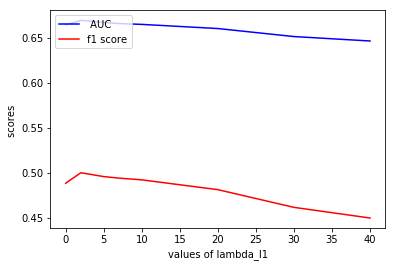

In [72]:
#lambda_l1': choice([0, 10, 20, 30, 40]),

X_train_lgbm, X_test_lgbm, y_train_lgbm, y_test_lgbm = train_test_split(X_selected_scaled,y, test_size=0.33, random_state=250)

auc=[]
f1=[]
lambda_l1=[0,2,5,7, 10, 20, 30, 40]
for i in lambda_l1:
    print('lambda_l1 = {}: '.format(i))
    clf_lgb = LGBMClassifier(lambda_l1=i)
    clf_lgb.fit(X_train_lgbm, y_train_lgbm)
    predict = clf_lgb.predict(X_test_lgbm)
    auc.append(metrics.roc_auc_score(y_test_lgbm, predict))
    f1.append(metrics.f1_score(y_test_lgbm, predict))
    print(" the auc value is ",metrics.roc_auc_score(y_test_lgbm, predict))
    print(" the f1 score is ",metrics.f1_score(y_test_lgbm, predict))


line1 = plt.plot(lambda_l1, auc, color="blue", label=" AUC")
line2 = plt.plot(lambda_l1, f1,color="red", label="f1 score")
plt.legend(loc='upper left')
plt.xlabel('values of lambda_l1')
plt.ylabel("scores ")

scale_pos_weight = 1: 
 the auc value is  0.6732249018817723
 the f1 score is  0.5083293669681104
scale_pos_weight = 2: 
 the auc value is  0.6851505346920976
 the f1 score is  0.5231607629427792
scale_pos_weight = 3: 
 the auc value is  0.7089315384354549
 the f1 score is  0.5274725274725275
scale_pos_weight = 4: 
 the auc value is  0.7245921104822678
 the f1 score is  0.4991757335970986
scale_pos_weight = 5: 
 the auc value is  0.7543103808572265
 the f1 score is  0.4405204460966543
scale_pos_weight = 6: 
 the auc value is  0.7740008382533734
 the f1 score is  0.4024078803356439
scale_pos_weight = 7: 
 the auc value is  0.7849196404421372
 the f1 score is  0.387981711299804
scale_pos_weight = 8: 
 the auc value is  0.7909323932488667
 the f1 score is  0.38157081014223876
scale_pos_weight = 9: 
 the auc value is  0.7980441411766932
 the f1 score is  0.3785545023696682
scale_pos_weight = 10: 
 the auc value is  0.7939813131795037
 the f1 score is  0.3667613636363637
scale_pos_weight = 

Text(0, 0.5, 'scores ')

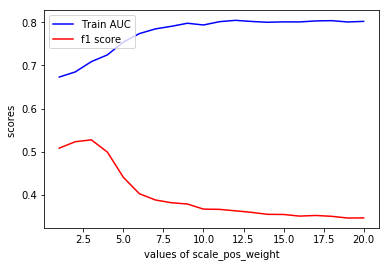

In [73]:
X_train_lgbm, X_test_lgbm, y_train_lgbm, y_test_lgbm = train_test_split(X_selected_scaled,y, test_size=0.33, random_state=300)

auc=[]
f1=[]
scale_pos_weight = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
for i in scale_pos_weight:
    print('scale_pos_weight = {}: '.format(i))
    clf_lgb = LGBMClassifier(scale_pos_weight=i)
    clf_lgb.fit(X_train_lgbm, y_train_lgbm)
    predict = clf_lgb.predict(X_test_lgbm)
    auc.append(metrics.roc_auc_score(y_test_lgbm, predict))
    f1.append(metrics.f1_score(y_test_lgbm, predict))
    print(" the auc value is ",metrics.roc_auc_score(y_test_lgbm, predict))
    print(" the f1 score is ",metrics.f1_score(y_test_lgbm, predict))

line1 = plt.plot(scale_pos_weight, auc, color="blue", label="Train AUC")
line2 = plt.plot(scale_pos_weight, f1,color="red", label="f1 score")
plt.legend(loc='upper left')
plt.xlabel('values of scale_pos_weight')
plt.ylabel("scores ")

#Best params 

num_leaves=21,
	earning_rate=0.3,
	is_unbalance=False,
	max_bin=20,
	max_depth=5,
	feature_fraction=0.6,
	lambda_l1=2,
	scale_pos_weight=3

In [75]:
Model_final=LGBMClassifier(num_leaves=21, earning_rate=0.3, is_unbalance=False, max_bin=20, max_depth=5, feature_fraction=0.6, lambda_l1=2, scale_pos_weight=3)

In [76]:
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_selected_scaled,y, test_size=0.33, random_state=50)


In [77]:
Model_final.fit(X_train_final, y_train_final)
predict_final = Model_final.predict(X_test_final)
print(metrics.roc_auc_score(y_test_final, predict_final))
print(metrics.f1_score(y_test_final, predict_final))

0.6986471166410959
0.5098199672667757


In [79]:
scaler = StandardScaler()
cols=list(X_train_final.columns)
test_selected=test[cols]
scaled_test = scaler.fit_transform(test_selected)
test_scaled=pd.DataFrame(scaled_test)
test_scaled.columns=cols 
pred_test=Model_final.predict(test_scaled)
# for submissions                          
ids=testCopy['employee_id']
submission = pd.DataFrame({'employee_id': ids,
                           'is_promoted':pred_test
                           })

submission.to_csv("Model_final.csv")